In [1]:
import os
import cdsapi

import numpy as np
import pandas as pd
import pandas_profiling
import geopandas
import netCDF4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimension
import salem

import matplotlib.pyplot as plt
%matplotlib inline 
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import dask

In [3]:
# Read the data Path where they are stored on the Computer
#data_dir = input('Path to the data\n')
paths = []
for folder in ['dekadal', 'seasonal', 'annual']:
    paths += [os.path.join('C:\\'
                'Users',
                'kurt_',
                'Data',
                'agroclimate',
                 folder,'')]
dekadal_dir, seasonal_dir, annual_dir = paths

In [14]:
# Import data as xarray dataset from the directory
def read_nc_files(data_dir, chunk, dask=False):
    dask = True
    if dask:
        # Import with dask
        dt = xarr.open_mfdataset(data_dir+'*hist_*.nc', parallel=True, 
                                  combine='by_coords', 
                                 chunks= chunk, # first spatial subsetting operations will be made.
                                 engine='netcdf4') # if available, h5netcdf engine is fatser than netcdf4
    else:
        # Import without dask for debugging
        dt = xarr.open_mfdataset(data_dir+'*hist_*.nc', parallel=True, 
                              combine='by_coords', engine='netcdf4')
    return dt

clim_dek = read_nc_files(dekadal_dir, chunk={'time':54}, dask=True) # The size on the disk is 2.4gb
clim_seas = read_nc_files(seasonal_dir, chunk=None)
clim_ann = read_nc_files(annual_dir, chunk=None)

In [17]:
(clim_dek['TG'][1].values)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

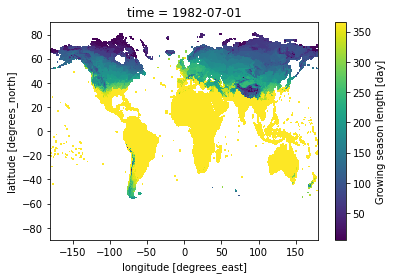

In [21]:
clim_ann['GSL'].isel(time=1).plot()

In [4]:
def gavg(da):
    """calculate global average
    e.g., x1=gavg(d1['t2m'])"""
    weights = np.cos(np.deg2rad(da.lat))
    ga = da.weighted(weights).mean(("lon", "lat"))

    return ga

def anomaly(da):
    """calculate anomaly"""

    clim = da.mean(dim='time')
    anom = da - clim

    return anom

def covmat(a,b):
    """covmat(a,b): calculate covariance between vector a and each grid point of matrix b
     returns a matrix with dimensions of b"""

    b1 = b.values
    s1 = np.shape(b1)
    a1 = a.values
    b1 = b1.reshape(s1[0],s1[1]*s1[2])

    a1 = a1 - np.average(a1);
    b1 = b1 - np.average(b1,axis=0)

    c1 = np.matrix(a)*np.matrix(b1)
    c1 = c1.reshape(s1[1],s1[2])/s1[0]
    c1 = xarr.DataArray(c1,dims=['lat','lon'],coords={'lat': b.lat, 'lon': b.lon})

    return c1


def detrend_2d(da):
    """linear detrend of 2D data set (lat x lon x time)
    returns anomaly"""

    da1 = anomaly(da)

    t1 = xarr.DataArray(np.arange(len(da1.time)),dims='time',coords={'time': da1.time})
    slope = covmat(t1,da1)/np.std(t1)**2

    da1 -= slope*t1 # remove linear trend
    da2 = anomaly(da1)

    return da1

In [30]:
da1 = anomaly(clim_dek['TG'])
t1 = xarr.DataArray(np.arange(len(da1.time)),dims='time',coords={'time': da1.time})
slope = covmat(t1,da1)/np.std(t1)**2
da1 -= slope*t1

C:\Users\kurt_\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
# selecting U.S. only
clim_dek = clim_dek.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_seas = clim_seas.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_ann = clim_ann.sel(lon=slice(-140, -50) ,lat=slice(15,60))

# # Write them to disk and re-read them without chunks
# ds_dict = {'dekadal':clim_dek, 'seasonal': clim_seas,
#            'annual': clim_ann}
# for ds_key in ds_dict:
#     # write the data into folders with paths dek_dir, seas_dir or ann_dir 
#     ds_dict[ds_key].to_netcdf(f'{eval(ds_key+"_dir")}{ds_key}.nc')

In [4]:
# Reading the us data from the disk
clim_dek = xarr.open_dataset(dekadal_dir+"dekadal.nc", chunks={'time':135}) # this is now only ~300 mb. No need chunks
clim_seas = xarr.open_dataset(seasonal_dir+"seasonal.nc")
clim_ann = xarr.open_dataset(annual_dir+"annual.nc")

In [5]:
# Import data as xarray dataset from the directory
def read_nc_files(data_dir, chunk, dask=False):
    dask = True
    if dask:
        # Import with dask
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                                  combine='by_coords', 
                                 chunks= chunk, # first spatial subsetting operations will be made.
                                 engine='netcdf4') # if available, h5netcdf engine is fatser than netcdf4
    else:
        # Import without dask for debugging
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                              combine='by_coords', engine='netcdf4')
    return dt
clim_dek = read_nc_files(dekadal_dir, chunk={'time':20}, dask=True) # The size on the disk is 2.4gb
clim_seas = read_nc_files(seasonal_dir, chunk=None)
clim_ann = read_nc_files(annual_dir, chunk=None)

In [6]:
# selecting U.S. only
clim_dek = clim_dek.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_seas = clim_seas.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_ann = clim_ann.sel(lon=slice(-140, -50) ,lat=slice(15,60))

# Write them to disk and re-read them without chunks
ds_dict = {'dekadal':clim_dek, 'seasonal': clim_seas,
           'annual': clim_ann}
for ds_key in ds_dict:
    # write the data into folders with paths dek_dir, seas_dir or ann_dir 
    ds_dict[ds_key].to_netcdf(f'{eval(ds_key+"_dir")}{ds_key}.nc')

In [23]:
# create a list of variables to keep
vars_to_keep = ['BEDD', 'CSDI', 'FD', 'GSL', 'R10mm', 
        'ID', 'CDD','CFD', 'CSU', 'CWD', 'TX',
       'TG', 'DTR', 'RR', 'SU', 'TR', 'R20mm',
       'WW', 'WSDI', 'RR1']
# Drop all but these variables in the vars_to_keep
def DropVars(ds):
    for var in ds:
        if var not in vars_to_keep:
            ds = ds.drop_vars(var)
    return ds
    
clim_dek = DropVars(clim_dek)
clim_ann = clim_ann.drop_vars('time_bounds')
clim_seas = clim_seas.drop_vars('time_bounds')

In [8]:
def resample_with_cell_method(ds, frq='AS'):
    """Resample the input dataset to a frequency given as frq as input
    with resampling method unique for each variable, in accordance with 
    their cell method, how they originally aggregated """

    # Resampling annualy
    ds_resampled = ds.resample(time=frq, keep_attrs=True)
    
    # creating a list to merge indpendently resampled variables
    dt_arrays_to_merge = []

    # iterate over each variable
    for var in ds:
        # skip time_bounds variable
        if var == "time_bounds":
            continue
        # resampling method based on each variable's cell_method
        if "mean" in ds[var].cell_methods:
            vars()[var] = ds_resampled.mean(keep_attrs=True)[var]
        elif "maximum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.max(keep_attrs=True)[var]
        elif "minimum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.min(keep_attrs=True)[var]
        elif "sum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.sum(keep_attrs=True)[var]
        # appending resampled variable to the list
        dt_arrays_to_merge.append(eval(var))

    # Merge all variables back to a dataset
    return xarr.merge(dt_arrays_to_merge)

In [24]:
# Selecting the relavant months in each year
sel_dates = clim_dek.time.values[(clim_dek.time.dt.month > 4) & (clim_dek.time.dt.month < 12)]
clim_dek_subset = clim_dek.sel(time=sel_dates)

In [25]:
clim_dek_to_ann = resample_with_cell_method(clim_dek_subset)
clim_dek_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

In [26]:
# Selecting the summer and fall seasons in each year
sel_dates = clim_seas.time.values[clim_seas.time.dt.month >= 7]
clim_seas_subset = clim_seas.sel(time=sel_dates)

In [27]:
clim_seas_to_ann = resample_with_cell_method(clim_seas_subset)
clim_seas_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

In [28]:
# fix the time dimension in clim_ann to match the others
clim_ann['time'] = clim_seas_to_ann['time']
clim_ann.time.values[:5]

array(['1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
# Combine all the data to agro_clim dataset
agro_clim = xarr.merge([clim_dek_to_ann, clim_seas_to_ann, clim_ann])
# Let's save agro_clim to disk. This will save time when repeating the work
agro_clim.to_netcdf('C:\\Users\\kurt_\\Data\\agro_clim_test1.nc')

C:\Users\kurt_\Anaconda3\lib\site-packages\dask\utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [40]:
del agro_clim

In [41]:
agro_clim = xarr.open_dataset('C:\\Users\\kurt_\\Data\\agro_clim_test1.nc')

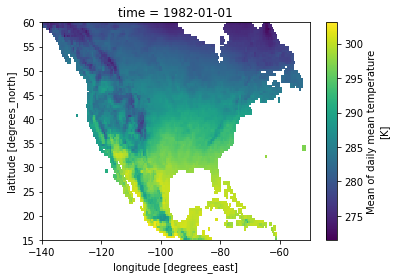

In [42]:
agro_clim.TG.isel(time=1).plot()

In [43]:
agro_clim

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180, time: 30)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2010-01-01
  * lat      (lat) float64 15.25 15.75 16.25 16.75 ... 58.25 58.75 59.25 59.75
  * lon      (lon) float64 -139.8 -139.2 -138.8 -138.2 ... -51.25 -50.75 -50.25
Data variables: (12/20)
    BEDD     (time, lat, lon) float32 ...
    DTR      (time, lat, lon) float32 ...
    FD       (time, lat, lon) float32 ...
    ID       (time, lat, lon) float32 ...
    R10mm    (time, lat, lon) float32 ...
    R20mm    (time, lat, lon) float32 ...
    ...       ...
    CSDI     (time, lat, lon) float32 ...
    CSU      (time, lat, lon) float32 ...
    CWD      (time, lat, lon) float32 ...
    WSDI     (time, lat, lon) float32 ...
    WW       (time, lat, lon) float32 ...
    GSL      (time, lat, lon) float32 ...